In [9]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import img_as_ubyte
import imageio


# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm import tqdm

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [10]:
ORIG_SHAPE = (512, 512, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults

body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

In [12]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "mike/pose_0_1_meshlab.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

texture_image = mesh.textures.maps_padded()
verticies = mesh.verts_list()
verticies[0].requires_grad = True

faces = mesh.faces_list()
texture = mesh.textures.clone()
maps = texture.maps_padded()
faces_uvs = texture.faces_uvs_padded()
verts_uvs = texture.verts_uvs_padded()
verts_rgb = texture.verts_rgb_padded()
new_texture = Textures(maps, faces_uvs, verts_uvs, verts_rgb)

In [22]:
print(maps.type())

torch.cuda.FloatTensor


In [4]:
new_mesh = Meshes(verticies, faces, new_texture)

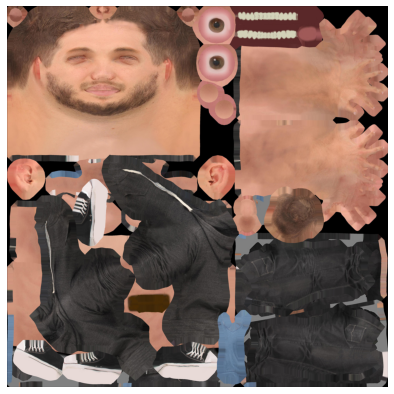

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

In [6]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0], 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

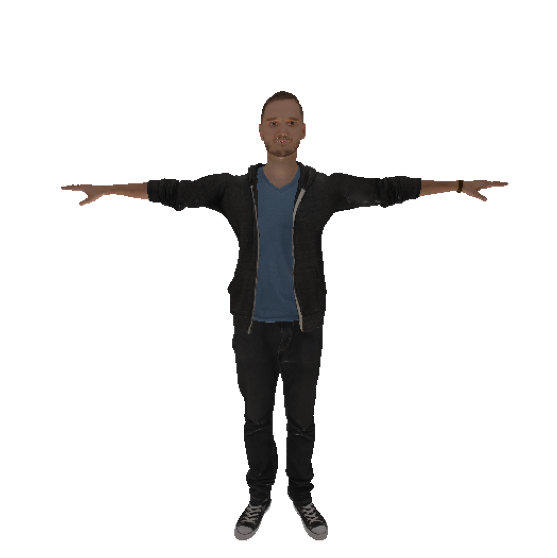

In [7]:
images = renderer(new_mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.grid("off");
plt.axis("off");

In [8]:
def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)

body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
paf, heat = body_estimation.model(body_input)
ATTRIBUTION_INDEX = 4
heatmap_attr = heat[0, ATTRIBUTION_INDEX, :, :]
zero_heatmap = torch.zeros_like(heatmap_attr, device=device)
peak_tensor = where(heatmap_attr > 0.3, heatmap_attr, zero_heatmap)
loss = peak_tensor.mean()

print(loss.item())
loss.backward(retain_graph=True)

0.00016439837054349482


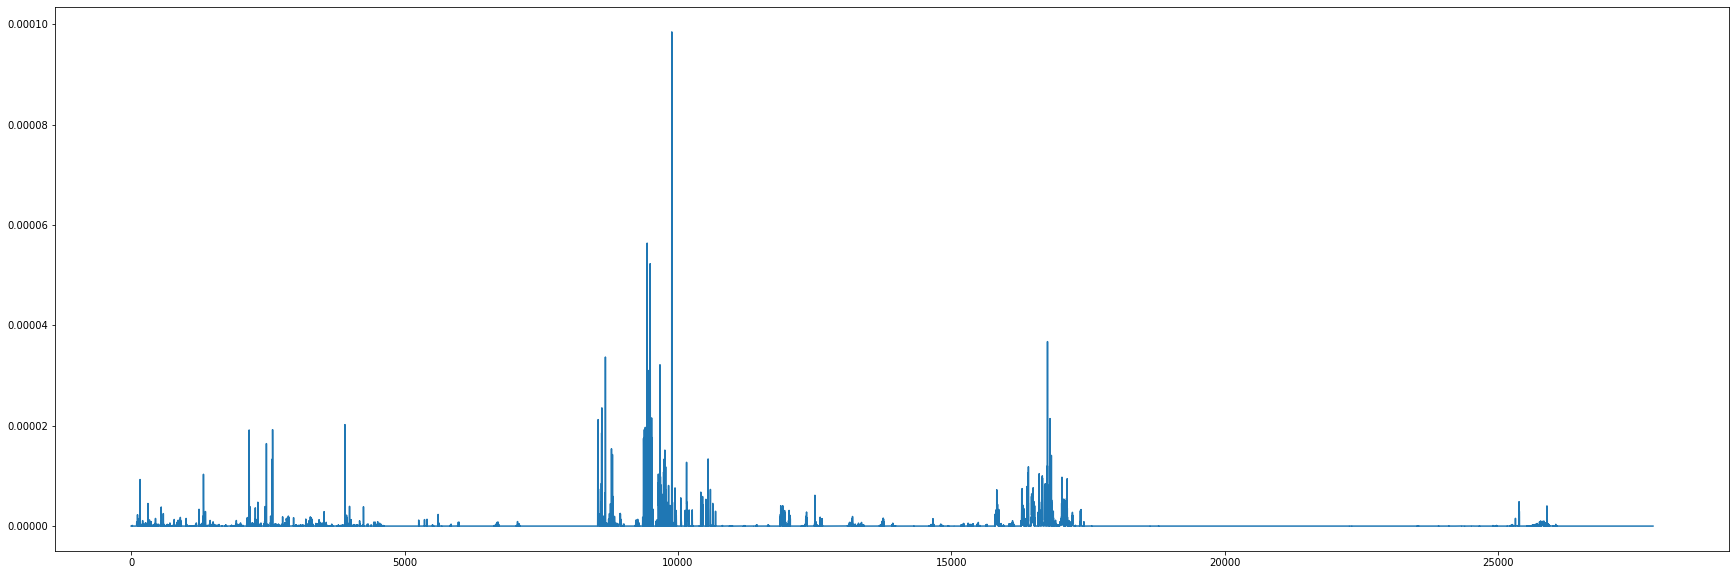

In [9]:
grad_np = verticies[0].grad.detach().cpu().numpy()
grad_norm = np.linalg.norm(grad_np, axis=1)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(grad_norm)

grad_norm /= 0.00001 # scale up to have a nice vis

color_map = cm.get_cmap('plasma')

rgb_vertex_colormap = np.array([color_map(grad_norm)[:, :3]], dtype=np.float32)

In [10]:
rgb_vertex_colormap.shape

(1, 27829, 3)

In [11]:
verts_rgb = torch.from_numpy(rgb_vertex_colormap).cuda()
new_texture = Textures(verts_rgb= verts_rgb)
heat_mesh = Meshes(verticies, faces, new_texture)
heat_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

Text(0.5, 1.0, '3D Saliceny map')

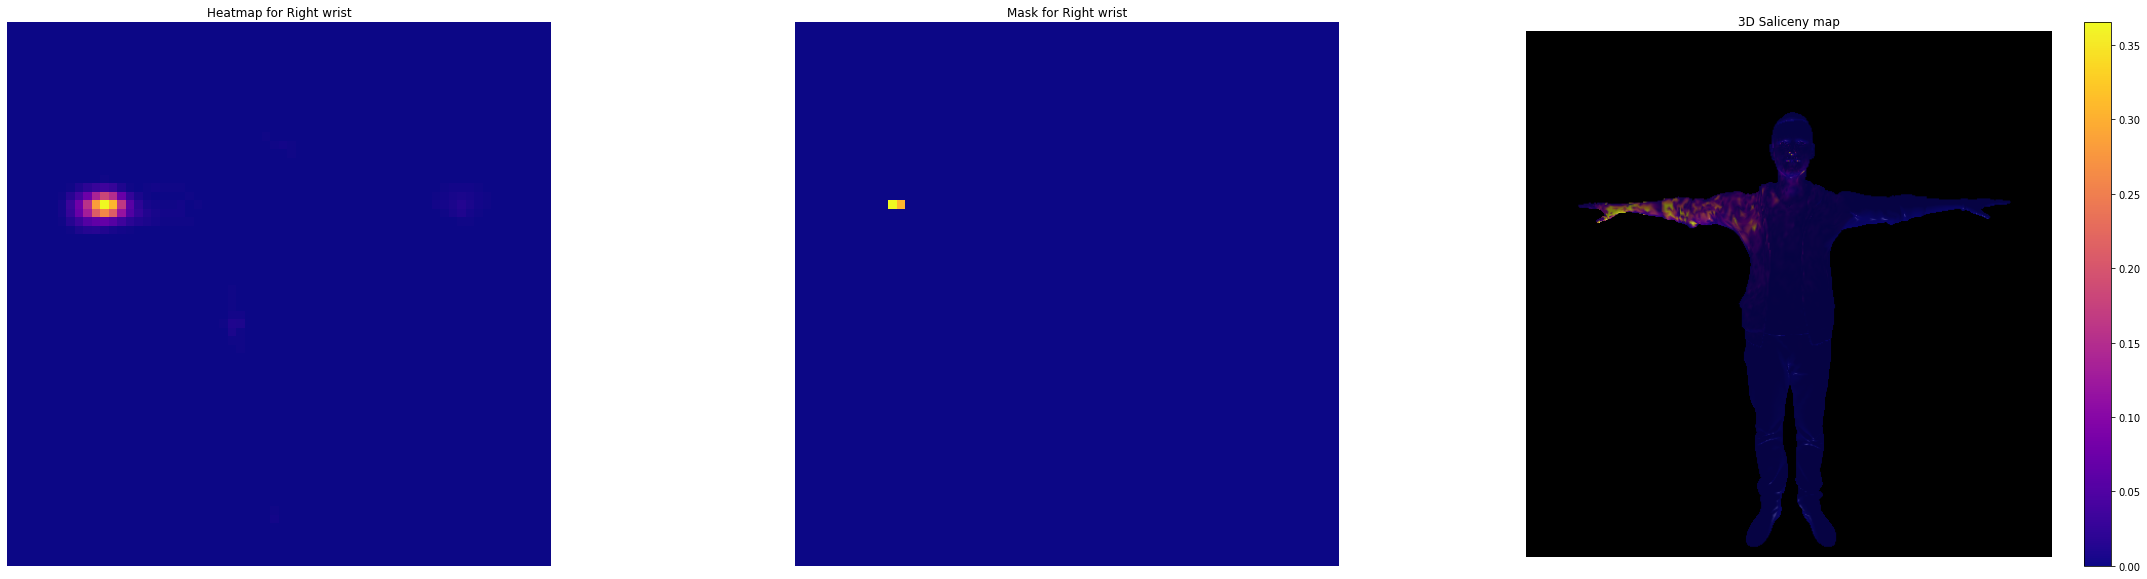

In [12]:
heat_images = heat_renderer(heat_mesh)

heatmap = heat[0, ATTRIBUTION_INDEX, :, :].detach().cpu().numpy()
peak_np = peak_tensor.detach().cpu().numpy()
fig = plt.figure(figsize=(40, 10))

ax = fig.add_subplot(1, 3, 1)
pcm = ax.imshow(heatmap,  cmap='plasma')
ax.axis('off')
ax.set_title('Heatmap for Right wrist')

ax = fig.add_subplot(1, 3, 2)
pcm = ax.imshow(peak_np,  cmap='plasma')
ax.axis('off')
ax.set_title('Mask for Right wrist')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(heat_images.detach().cpu().numpy()[0])
ax.axis('off')
fig.colorbar(pcm, ax=ax, cmap='plasma')
ax.set_title('3D Saliceny map')

In [17]:
filename_output = "./attribution_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.30)

In [18]:
for rot in tqdm(range(0, 360, 2)):
    R, T = look_at_view_transform(200.0, 10, rot) 
    T[0, 1] = -100
    heat_images = heat_renderer(meshes_world=heat_mesh, R=R.cuda(), T=T.cuda())
    image = heat_images[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)
    writer.append_data(image)
    
writer.close()

100%|██████████| 180/180 [00:12<00:00, 14.95it/s]


![SegmentLocal](attribution_demo.gif "segment")